# Importing Libraries

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

# MLflow Setup

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/reino/Programming/MLOps/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1717001252155, experiment_id='1', last_update_time=1717001252155, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

# 1. Loading the Data

In [3]:
df_january = pd.read_parquet("./data/green_tripdata_2023-01.parquet")

df_january.lpep_dropoff_datetime = pd.to_datetime(df_january.lpep_dropoff_datetime)
df_january.lpep_pickup_datetime = pd.to_datetime(df_january.lpep_pickup_datetime)

df_january['duration'] = df_january.lpep_dropoff_datetime - df_january.lpep_pickup_datetime
df_january.duration = df_january.duration.apply(lambda td: td.total_seconds() / 60)

df_january = df_january[(df_january.duration >= 1) & (df_january.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_january[categorical] = df_january[categorical].astype(str)

# 2. Data Preprocessing

In [4]:
df_january

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.90,...,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.70,...,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.20,...,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.50,...,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.00,...,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,None,NaN,49,62,NaN,4070.82,15.70,...,0.0,0.00,0.0,None,1.0,16.70,NaN,NaN,NaN,13.000000
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,None,NaN,10,205,NaN,2.14,4.41,...,0.0,0.00,0.0,None,1.0,5.41,NaN,NaN,NaN,8.000000
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,None,NaN,66,37,NaN,3.44,16.53,...,0.0,3.51,0.0,None,1.0,21.04,NaN,NaN,NaN,16.000000
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,None,NaN,225,189,NaN,3.03,14.98,...,0.0,3.20,0.0,None,1.0,19.18,NaN,NaN,NaN,18.000000


In [5]:
train_dicts = df_january[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_january[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.0603515317164085

/tmp/ipykernel_25091/1505421196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_25091/1505421196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


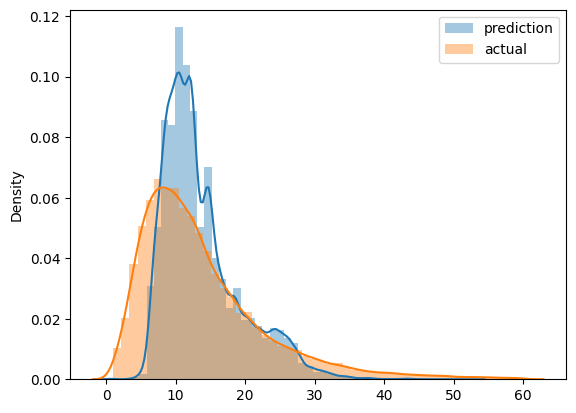

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

In [7]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [8]:
df_train = read_dataframe('./data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2023-02.parquet')

In [9]:
len(df_train), len(df_val)

(65946, 62574)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.037713760833734

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [15]:
with mlflow.start_run():

    mlflow.set_tag("developer", "reinoteguhsts15")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2023-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Using XGBoost

In [16]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {"loss": rmse, "status": STATUS_OK}

In [21]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:30:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.25378                           
[1]	validation-rmse:7.44725                           
[2]	validation-rmse:6.82892                           
[3]	validation-rmse:6.38711                           
[4]	validation-rmse:6.08409                           
[5]	validation-rmse:5.84752                           
[6]	validation-rmse:5.68294                           
[7]	validation-rmse:5.56455                           
[8]	validation-rmse:5.49560                           
[9]	validation-rmse:5.42901                           
[10]	validation-rmse:5.39733                          
[11]	validation-rmse:5.37495                          
[12]	validation-rmse:5.34808                          
[13]	validation-rmse:5.33610                          
[14]	validation-rmse:5.33015                          
[15]	validation-rmse:5.32482                          
[16]	validation-rmse:5.32061                          
[17]	validation-rmse:5.31063                          
[18]	valid

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  2%|▏         | 1/50 [00:53<43:40, 53.48s/trial, best loss: 5.2930750477643755]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:31:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.96832                                                     
[1]	validation-rmse:7.04232                                                     
[2]	validation-rmse:6.42580                                                     
[3]	validation-rmse:6.02128                                                     
[4]	validation-rmse:5.75840                                                     
[5]	validation-rmse:5.58942                                                     
[6]	validation-rmse:5.48347                                                     
[7]	validation-rmse:5.40816                                                     
[8]	validation-rmse:5.35889                                                     
[9]	validation-rmse:5.32650                                                     
[10]	validation-rmse:5.30821                                                    
[11]	validation-rmse:5.28440                                                    
[12]	validation-rmse:5.27437

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  4%|▍         | 2/50 [01:42<40:55, 51.15s/trial, best loss: 5.139459120531955] 

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:32:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.88091                                                    
[1]	validation-rmse:6.92251                                                    
[2]	validation-rmse:6.31663                                                    
[3]	validation-rmse:5.91832                                                    
[4]	validation-rmse:5.69173                                                    
[5]	validation-rmse:5.53393                                                    
[6]	validation-rmse:5.44512                                                    
[7]	validation-rmse:5.38846                                                    
[8]	validation-rmse:5.35239                                                    
[9]	validation-rmse:5.32661                                                    
[10]	validation-rmse:5.31267                                                   
[11]	validation-rmse:5.30354                                                   
[12]	validation-rmse:5.29852            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  6%|▌         | 3/50 [02:20<35:11, 44.93s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:32:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.60698                                                    
[1]	validation-rmse:8.00565                                                    
[2]	validation-rmse:7.50805                                                    
[3]	validation-rmse:7.09443                                                    
[4]	validation-rmse:6.75032                                                    
[5]	validation-rmse:6.47209                                                    
[6]	validation-rmse:6.23772                                                    
[7]	validation-rmse:6.05802                                                    
[8]	validation-rmse:5.90652                                                    
[9]	validation-rmse:5.77545                                                    
[10]	validation-rmse:5.68080                                                   
[11]	validation-rmse:5.60187                                                   
[12]	validation-rmse:5.54181            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.88009                                                    
[1]	validation-rmse:8.48418                                                    
[2]	validation-rmse:8.13068                                                    
[3]	validation-rmse:7.81642                                                    
  8%|▊         | 4/50 [03:18<38:03, 49.63s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:33:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.53549                                                    
[5]	validation-rmse:7.28674                                                    
[6]	validation-rmse:7.06664                                                    
[7]	validation-rmse:6.87431                                                    
[8]	validation-rmse:6.70389                                                    
[9]	validation-rmse:6.55386                                                    
[10]	validation-rmse:6.42377                                                   
[11]	validation-rmse:6.30956                                                   
[12]	validation-rmse:6.20891                                                   
[13]	validation-rmse:6.12141                                                   
[14]	validation-rmse:6.04299                                                   
[15]	validation-rmse:5.97582                                                   
[16]	validation-rmse:5.91789            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:7.24828                                                    
 10%|█         | 5/50 [04:23<41:25, 55.23s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:34:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.23631                                                    
[2]	validation-rmse:5.77708                                                    
[3]	validation-rmse:5.57316                                                    
[4]	validation-rmse:5.47462                                                    
[5]	validation-rmse:5.42199                                                    
[6]	validation-rmse:5.39898                                                    
[7]	validation-rmse:5.38093                                                    
[8]	validation-rmse:5.37233                                                    
[9]	validation-rmse:5.35663                                                    
[10]	validation-rmse:5.35176                                                   
[11]	validation-rmse:5.34580                                                   
[12]	validation-rmse:5.33615                                                   
[13]	validation-rmse:5.33196            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 12%|█▏        | 6/50 [05:10<38:35, 52.62s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:35:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.73966                                                    
[1]	validation-rmse:8.23523                                                    
[2]	validation-rmse:7.80031                                                    
[3]	validation-rmse:7.42702                                                    
[4]	validation-rmse:7.10816                                                    
[5]	validation-rmse:6.83640                                                    
[6]	validation-rmse:6.60657                                                    
[7]	validation-rmse:6.41237                                                    
[8]	validation-rmse:6.24936                                                    
[9]	validation-rmse:6.11309                                                    
[10]	validation-rmse:5.99870                                                   
[11]	validation-rmse:5.90351                                                   
[12]	validation-rmse:5.82350            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 14%|█▍        | 7/50 [07:29<58:05, 81.05s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:37:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.11037                                                    
[1]	validation-rmse:5.44922                                                    
[2]	validation-rmse:5.31300                                                    
[3]	validation-rmse:5.27148                                                    
[4]	validation-rmse:5.25974                                                    
[5]	validation-rmse:5.25494                                                    
[6]	validation-rmse:5.24778                                                    
[7]	validation-rmse:5.24153                                                    
[8]	validation-rmse:5.23862                                                    
[9]	validation-rmse:5.23208                                                    
[10]	validation-rmse:5.22774                                                   
[11]	validation-rmse:5.22462                                                   
[12]	validation-rmse:5.22196            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 16%|█▌        | 8/50 [07:41<41:25, 59.17s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:38:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.31858                                                    
[1]	validation-rmse:6.26980                                                    
[2]	validation-rmse:5.75108                                                    
[3]	validation-rmse:5.50013                                                    
[4]	validation-rmse:5.38365                                                    
[5]	validation-rmse:5.31730                                                    
[6]	validation-rmse:5.28421                                                    
[7]	validation-rmse:5.26258                                                    
[8]	validation-rmse:5.24534                                                    
[9]	validation-rmse:5.23948                                                    
[10]	validation-rmse:5.23608                                                   
[11]	validation-rmse:5.23369                                                   
[12]	validation-rmse:5.22938            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 18%|█▊        | 9/50 [08:05<32:53, 48.14s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:38:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.41846                                                    
[1]	validation-rmse:5.64394                                                    
[2]	validation-rmse:5.44472                                                    
[3]	validation-rmse:5.37576                                                    
[4]	validation-rmse:5.34579                                                    
[5]	validation-rmse:5.32875                                                    
[6]	validation-rmse:5.31903                                                    
[7]	validation-rmse:5.30231                                                    
[8]	validation-rmse:5.30037                                                    
[9]	validation-rmse:5.29239                                                    
[10]	validation-rmse:5.29013                                                   
[11]	validation-rmse:5.28736                                                   
[12]	validation-rmse:5.28577            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:7.91469                                                     
 20%|██        | 10/50 [08:43<29:49, 44.75s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:39:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.98075                                                     
[2]	validation-rmse:6.38268                                                     
[3]	validation-rmse:6.00194                                                     
[4]	validation-rmse:5.76397                                                     
[5]	validation-rmse:5.61934                                                     
[6]	validation-rmse:5.52699                                                     
[7]	validation-rmse:5.46526                                                     
[8]	validation-rmse:5.42707                                                     
[9]	validation-rmse:5.40140                                                     
[10]	validation-rmse:5.38189                                                    
[11]	validation-rmse:5.36686                                                    
[12]	validation-rmse:5.35538                                                    
[13]	validation-rmse:5.34773

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 22%|██▏       | 11/50 [09:10<25:42, 39.56s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:39:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.96754                                                     
[1]	validation-rmse:8.64039                                                     
[2]	validation-rmse:8.33870                                                     
[3]	validation-rmse:8.06093                                                     
[4]	validation-rmse:7.80492                                                     
[5]	validation-rmse:7.57005                                                     
[6]	validation-rmse:7.35475                                                     
[7]	validation-rmse:7.15799                                                     
[8]	validation-rmse:6.97785                                                     
[9]	validation-rmse:6.81400                                                     
[10]	validation-rmse:6.66453                                                    
[11]	validation-rmse:6.52884                                                    
[12]	validation-rmse:6.40580

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 24%|██▍       | 12/50 [12:22<54:19, 85.78s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:42:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.84980                                                     
[1]	validation-rmse:8.42498                                                     
[2]	validation-rmse:8.04393                                                     
[3]	validation-rmse:7.70333                                                     
[4]	validation-rmse:7.39974                                                     
[5]	validation-rmse:7.12992                                                     
[6]	validation-rmse:6.89064                                                     
[7]	validation-rmse:6.67949                                                     
[8]	validation-rmse:6.49287                                                     
[9]	validation-rmse:6.32883                                                     
[10]	validation-rmse:6.18527                                                    
[11]	validation-rmse:6.06014                                                    
[12]	validation-rmse:5.95093

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 26%|██▌       | 13/50 [15:09<1:08:01, 110.30s/trial, best loss: 5.139459120531955]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:45:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.20711                                                        
[1]	validation-rmse:7.38202                                                        
[2]	validation-rmse:6.78839                                                        
[3]	validation-rmse:6.36511                                                        
[4]	validation-rmse:6.06054                                                        
[5]	validation-rmse:5.85750                                                        
[6]	validation-rmse:5.71311                                                        
[7]	validation-rmse:5.60867                                                        
[8]	validation-rmse:5.53385                                                        
[9]	validation-rmse:5.48217                                                        
[10]	validation-rmse:5.44488                                                       
[11]	validation-rmse:5.41936                                                

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 28%|██▊       | 14/50 [16:19<58:55, 98.22s/trial, best loss: 5.134194057139093]   

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:46:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.46012                                                     
[1]	validation-rmse:5.31293                                                     
[2]	validation-rmse:5.28888                                                     
[3]	validation-rmse:5.25781                                                     
[4]	validation-rmse:5.24821                                                     
[5]	validation-rmse:5.24652                                                     
[6]	validation-rmse:5.23924                                                     
[7]	validation-rmse:5.23563                                                     
[8]	validation-rmse:5.23407                                                     
[9]	validation-rmse:5.23015                                                     
[10]	validation-rmse:5.23086                                                    
[11]	validation-rmse:5.22921                                                    
[12]	validation-rmse:5.22893

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 30%|███       | 15/50 [16:41<43:55, 75.30s/trial, best loss: 5.134194057139093]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:47:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.15750                                                     
[1]	validation-rmse:7.29680                                                     
[2]	validation-rmse:6.67411                                                     
[3]	validation-rmse:6.23252                                                     
[4]	validation-rmse:5.92375                                                     
[5]	validation-rmse:5.71186                                                     
[6]	validation-rmse:5.56450                                                     
[7]	validation-rmse:5.46171                                                     
[8]	validation-rmse:5.38817                                                     
[9]	validation-rmse:5.33806                                                     
[10]	validation-rmse:5.30230                                                    
[11]	validation-rmse:5.27778                                                    
[12]	validation-rmse:5.25999

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 32%|███▏      | 16/50 [17:26<37:25, 66.04s/trial, best loss: 5.134194057139093]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:47:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.09988                                                     
[1]	validation-rmse:6.09169                                                     
[2]	validation-rmse:5.67291                                                     
[3]	validation-rmse:5.49379                                                     
[4]	validation-rmse:5.41914                                                     
[5]	validation-rmse:5.37764                                                     
[6]	validation-rmse:5.35051                                                     
[7]	validation-rmse:5.33758                                                     
[8]	validation-rmse:5.33153                                                     
[9]	validation-rmse:5.32246                                                     
[10]	validation-rmse:5.31403                                                    
[11]	validation-rmse:5.31117                                                    
[12]	validation-rmse:5.30062

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 34%|███▍      | 17/50 [18:24<35:07, 63.86s/trial, best loss: 5.134194057139093]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:48:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99304                                                     
[1]	validation-rmse:8.68815                                                     
[2]	validation-rmse:8.40600                                                     
[3]	validation-rmse:8.14540                                                     
[4]	validation-rmse:7.90477                                                     
[5]	validation-rmse:7.68303                                                     
[6]	validation-rmse:7.47902                                                     
[7]	validation-rmse:7.29158                                                     
[8]	validation-rmse:7.11959                                                     
[9]	validation-rmse:6.96216                                                     
[10]	validation-rmse:6.81774                                                    
[11]	validation-rmse:6.68578                                                    
[12]	validation-rmse:6.56517

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 36%|███▌      | 18/50 [23:54<1:16:38, 143.71s/trial, best loss: 5.134194057139093]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:54:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99378                                                        
[1]	validation-rmse:8.68997                                                        
[2]	validation-rmse:8.40780                                                        
[3]	validation-rmse:8.14621                                                        
[4]	validation-rmse:7.90633                                                        
[5]	validation-rmse:7.68204                                                        
[6]	validation-rmse:7.47792                                                        
[7]	validation-rmse:7.28675                                                        
[8]	validation-rmse:7.11326                                                        
[9]	validation-rmse:6.95286                                                        
[10]	validation-rmse:6.80657                                                       
[11]	validation-rmse:6.67337                                                

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 38%|███▊      | 19/50 [26:31<1:16:22, 147.82s/trial, best loss: 5.134194057139093]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:57:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.45737                                                        
[1]	validation-rmse:7.75386                                                        
[2]	validation-rmse:7.18648                                                        
[3]	validation-rmse:6.73530                                                        
[4]	validation-rmse:6.38097                                                        
[5]	validation-rmse:6.10248                                                        
[6]	validation-rmse:5.88953                                                        
[7]	validation-rmse:5.72336                                                        
[8]	validation-rmse:5.59682                                                        
[9]	validation-rmse:5.49898                                                        
[10]	validation-rmse:5.42466                                                       
[11]	validation-rmse:5.36739                                                

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 40%|████      | 20/50 [28:12<1:06:54, 133.81s/trial, best loss: 5.13102101475251] 

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:58:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.50955                                                       
[1]	validation-rmse:7.84166                                                       
[2]	validation-rmse:7.29650                                                       
[3]	validation-rmse:6.85416                                                       
[4]	validation-rmse:6.50249                                                       
[5]	validation-rmse:6.21511                                                       
[6]	validation-rmse:5.99375                                                       
[7]	validation-rmse:5.81424                                                       
[8]	validation-rmse:5.67591                                                       
[9]	validation-rmse:5.56940                                                       
[10]	validation-rmse:5.48480                                                      
[11]	validation-rmse:5.41963                                                      
[12]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 42%|████▏     | 21/50 [29:33<56:58, 117.88s/trial, best loss: 5.13102101475251]  

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:00:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.41451                                                     
[1]	validation-rmse:7.68974                                                     
[2]	validation-rmse:7.11293                                                     
[3]	validation-rmse:6.65652                                                     
[4]	validation-rmse:6.30946                                                     
[5]	validation-rmse:6.03231                                                     
[6]	validation-rmse:5.83084                                                     
[7]	validation-rmse:5.66665                                                     
[8]	validation-rmse:5.54924                                                     
[9]	validation-rmse:5.46178                                                     
[10]	validation-rmse:5.39345                                                    
[11]	validation-rmse:5.34235                                                    
[12]	validation-rmse:5.30467

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 44%|████▍     | 22/50 [30:31<46:34, 99.79s/trial, best loss: 5.13102101475251] 

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:01:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.78418                                                    
[1]	validation-rmse:8.31152                                                    
[2]	validation-rmse:7.89538                                                    
[3]	validation-rmse:7.53346                                                    
[4]	validation-rmse:7.21972                                                    
[5]	validation-rmse:6.94039                                                    
[6]	validation-rmse:6.70400                                                    
[7]	validation-rmse:6.49746                                                    
[8]	validation-rmse:6.31985                                                    
[9]	validation-rmse:6.16986                                                    
[10]	validation-rmse:6.03899                                                   
[11]	validation-rmse:5.92916                                                   
[12]	validation-rmse:5.82855            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 46%|████▌     | 23/50 [32:19<46:02, 102.33s/trial, best loss: 5.13102101475251]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:02:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.38019                                                     
[1]	validation-rmse:7.63668                                                     
[2]	validation-rmse:7.05643                                                     
[3]	validation-rmse:6.60970                                                     
[4]	validation-rmse:6.27440                                                     
[5]	validation-rmse:6.01137                                                     
[6]	validation-rmse:5.82042                                                     
[7]	validation-rmse:5.67442                                                     
[8]	validation-rmse:5.56396                                                     
[9]	validation-rmse:5.48320                                                     
[10]	validation-rmse:5.42681                                                    
[11]	validation-rmse:5.37812                                                    
[12]	validation-rmse:5.34080

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 48%|████▊     | 24/50 [33:19<38:46, 89.49s/trial, best loss: 5.13102101475251] 

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:03:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.56544                                                    
[1]	validation-rmse:6.54383                                                    
[2]	validation-rmse:5.97739                                                    
[3]	validation-rmse:5.67134                                                    
[4]	validation-rmse:5.49275                                                    
[5]	validation-rmse:5.40706                                                    
[6]	validation-rmse:5.35381                                                    
[7]	validation-rmse:5.32680                                                    
[8]	validation-rmse:5.30447                                                    
[9]	validation-rmse:5.29238                                                    
[10]	validation-rmse:5.28425                                                   
[11]	validation-rmse:5.27896                                                   
[12]	validation-rmse:5.27654            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 50%|█████     | 25/50 [33:52<30:15, 72.60s/trial, best loss: 5.13102101475251]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:04:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67390                                                    
[1]	validation-rmse:8.11637                                                    
[2]	validation-rmse:7.63926                                                    
[3]	validation-rmse:7.23327                                                    
[4]	validation-rmse:6.89002                                                    
[5]	validation-rmse:6.60213                                                    
[6]	validation-rmse:6.36070                                                    
[7]	validation-rmse:6.15930                                                    
[8]	validation-rmse:5.99306                                                    
[9]	validation-rmse:5.85593                                                    
[10]	validation-rmse:5.74271                                                   
[11]	validation-rmse:5.64906                                                   
[12]	validation-rmse:5.57216            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.26566                                                    
[1]	validation-rmse:7.48671                                                    
[2]	validation-rmse:6.91863                                                    
[3]	validation-rmse:6.51384                                                    
[4]	validation-rmse:6.22656                                                    
 52%|█████▏    | 26/50 [35:53<34:49, 87.06s/trial, best loss: 5.13102101475251]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:06:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.02593                                                    
[6]	validation-rmse:5.88664                                                    
[7]	validation-rmse:5.78753                                                    
[8]	validation-rmse:5.71668                                                    
[9]	validation-rmse:5.66567                                                    
[10]	validation-rmse:5.63165                                                   
[11]	validation-rmse:5.60818                                                   
[12]	validation-rmse:5.59083                                                   
[13]	validation-rmse:5.57258                                                   
[14]	validation-rmse:5.55913                                                   
[15]	validation-rmse:5.55008                                                   
[16]	validation-rmse:5.54275                                                   
[17]	validation-rmse:5.53709            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 54%|█████▍    | 27/50 [36:38<28:37, 74.68s/trial, best loss: 5.13102101475251]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:07:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.49526                                                    
[1]	validation-rmse:5.58529                                                    
[2]	validation-rmse:5.32653                                                    
[3]	validation-rmse:5.24805                                                    
[4]	validation-rmse:5.21305                                                    
[5]	validation-rmse:5.19800                                                    
[6]	validation-rmse:5.19392                                                    
[7]	validation-rmse:5.18898                                                    
[8]	validation-rmse:5.18685                                                    
[9]	validation-rmse:5.18318                                                    
[10]	validation-rmse:5.18409                                                   
[11]	validation-rmse:5.18460                                                   
[12]	validation-rmse:5.18361            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 56%|█████▌    | 28/50 [36:58<21:16, 58.02s/trial, best loss: 5.13102101475251]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:07:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.32008                                                    
[1]	validation-rmse:7.54994                                                    
[2]	validation-rmse:6.96627                                                    
[3]	validation-rmse:6.52398                                                    
[4]	validation-rmse:6.19767                                                    
[5]	validation-rmse:5.96386                                                    
[6]	validation-rmse:5.78564                                                    
[7]	validation-rmse:5.65269                                                    
[8]	validation-rmse:5.56004                                                    
[9]	validation-rmse:5.49656                                                    
[10]	validation-rmse:5.44145                                                   
[11]	validation-rmse:5.40459                                                   
[12]	validation-rmse:5.37418            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 58%|█████▊    | 29/50 [37:42<18:55, 54.06s/trial, best loss: 5.13102101475251]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:08:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.68894                                                    
[1]	validation-rmse:6.68283                                                    
[2]	validation-rmse:6.07026                                                    
[3]	validation-rmse:5.72665                                                    
[4]	validation-rmse:5.54044                                                    
[5]	validation-rmse:5.45337                                                    
[6]	validation-rmse:5.37129                                                    
[7]	validation-rmse:5.34524                                                    
[8]	validation-rmse:5.32527                                                    
[9]	validation-rmse:5.31514                                                    
[10]	validation-rmse:5.30984                                                   
[11]	validation-rmse:5.30464                                                   
[12]	validation-rmse:5.30165            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 60%|██████    | 30/50 [38:12<15:32, 46.64s/trial, best loss: 5.13102101475251]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:08:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.55726                                                    
[1]	validation-rmse:7.92604                                                    
[2]	validation-rmse:7.41193                                                    
[3]	validation-rmse:6.99406                                                    
[4]	validation-rmse:6.65657                                                    
[5]	validation-rmse:6.38961                                                    
[6]	validation-rmse:6.16862                                                    
[7]	validation-rmse:5.99920                                                    
[8]	validation-rmse:5.86004                                                    
[9]	validation-rmse:5.75130                                                    
[10]	validation-rmse:5.66524                                                   
[11]	validation-rmse:5.59591                                                   
[12]	validation-rmse:5.54328            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 62%|██████▏   | 31/50 [39:53<19:54, 62.89s/trial, best loss: 5.13102101475251]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:10:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.99250                                                    
[1]	validation-rmse:7.05316                                                    
[2]	validation-rmse:6.41076                                                    
[3]	validation-rmse:5.97922                                                    
[4]	validation-rmse:5.70079                                                    
[5]	validation-rmse:5.51604                                                    
[6]	validation-rmse:5.39972                                                    
[7]	validation-rmse:5.32273                                                    
[8]	validation-rmse:5.27192                                                    
[9]	validation-rmse:5.24011                                                    
[10]	validation-rmse:5.22028                                                   
[11]	validation-rmse:5.20477                                                   
[12]	validation-rmse:5.19256            

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 64%|██████▍   | 32/50 [40:30<16:33, 55.20s/trial, best loss: 5.13102101475251]

/home/reino/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:11:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92121                                                    
[1]	validation-rmse:8.55564                                                    
[2]	validation-rmse:8.22388                                                    
[3]	validation-rmse:7.92080                                                    
[4]	validation-rmse:7.65088                                                    
[5]	validation-rmse:7.40041                                                    
[6]	validation-rmse:7.17930                                                    
[7]	validation-rmse:6.97591                                                    
[8]	validation-rmse:6.79804                                                    
[9]	validation-rmse:6.63635                                                    
[10]	validation-rmse:6.48984                                                   
[11]	validation-rmse:6.35844                                                   
[12]	validation-rmse:6.24217            

KeyboardInterrupt: 